In [19]:
!pip install tensorflow tensorflow_federated matplotlib
!pip install --upgrade tensorflow_federated

In [25]:
import tensorflow as tf
import tensorflow_federated as tff
import collections
import numpy as np
import matplotlib.pyplot as plt



#Load and Preprocess Data

In [28]:
# Load MNIST data
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data
mnist_x_train, mnist_x_test = mnist_x_train / 255.0, mnist_x_test / 255.0

# Parameters
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20

# Create a function to preprocess the data
def preprocess(dataset):
    def batch_format_fn(element):
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 28, 28, 1]),
            y=tf.reshape(element['label'], [-1])
        )
    return dataset.batch(BATCH_SIZE).map(batch_format_fn).prefetch(1)

# Function to create a federated dataset
def create_tf_dataset_for_client(client_id):
    def preprocess_fn(image, label):
        return collections.OrderedDict(  # Return a dictionary to match batch_format_fn's expectation
            pixels=tf.reshape(image, [28, 28, 1]),
            label=tf.reshape(label, [])
        )
    start = client_id * len(mnist_x_train) // NUM_CLIENTS
    end = (client_id + 1) * len(mnist_x_train) // NUM_CLIENTS
    client_data = tf.data.Dataset.from_tensor_slices((mnist_x_train[start:end], mnist_y_train[start:end]))
    return preprocess(client_data.map(preprocess_fn)) # Apply preprocess_fn to each element before batching

# Create federated data for clients
federated_train_data = [create_tf_dataset_for_client(client_id) for client_id in range(NUM_CLIENTS)]

# Function to create test dataset
def create_test_dataset():
    def preprocess_fn(image, label):
        return collections.OrderedDict(
            pixels=tf.reshape(image, [28, 28, 1]),
            label=tf.reshape(label, [])
        )
    return preprocess(tf.data.Dataset.from_tensor_slices((mnist_x_test, mnist_y_test)).map(preprocess_fn)) # Apply preprocess_fn to each element before batching

federated_test_data = [create_test_dataset()]

In [31]:
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )



#. Define Federated Computation

In [33]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

state = iterative_process.initialize()


In [34]:
NUM_ROUNDS = 10
for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}, Metrics={metrics}')


Round 1, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.76935), ('loss', 0.85383254), ('num_examples', 60000), ('num_batches', 3000)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.88975), ('loss', 0.3661351), ('num_examples', 60000), ('num_batches', 3000)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9080167), ('loss', 0.30623546), ('num_examples', 60000), ('num_batches', 3000)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('fina

In [47]:
def evaluate_model(keras_model, test_data):
    keras_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    # Convert test data to the expected format
    test_data = {'input_8': test_data['x']}  # Assuming 'input_8' is the expected input key
    evaluation_result = keras_model.evaluate(test_data)
    return evaluation_result

In [48]:
model = create_keras_model()
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 5408)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               692352    
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
Total params: 693962 (2.65 MB)
Trainable params: 693962 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

1/1 [==============================] - 0s 29ms/step


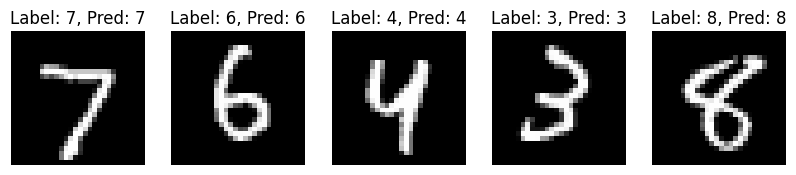

In [53]:
# Plot sample images with predictions
def plot_predictions(model, test_data, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 3)) # Create subplot axes here
    # Iterate over the test dataset directly
    for i, element in enumerate(test_data.take(num_images)):
        # Assuming 'x' contains a batch of images, access a single image
        image = element['x'][i].numpy().reshape(28, 28)  # Access 'x' for image data
        label = element['y'][i].numpy()  # Access 'y' for label data
        prediction = np.argmax(model.predict(image[None, ...]))
        axes[i].set_title(f'Label: {label}, Pred: {prediction}') # Use axes[i] to access the correct subplot
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    plt.show()

# Get a sample test data (no change needed here)
sample_test_data = next(iter(test_data))

# Plot predictions (use the original test_data)
plot_predictions(trained_model, test_data) # Make sure 'trained_model' is defined and contains your trained model

1/1 [==============================] - 0s 34ms/step


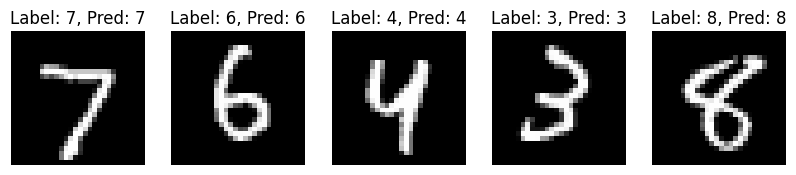

In [54]:
# Create a Keras model and assign weights from the federated training
trained_model = create_keras_model()
state_model_weights.assign_weights_to(trained_model)

# Create test dataset
test_data = create_test_dataset()

# Plot sample predictions
plot_predictions(trained_model, test_data)